In [1]:
import sys
sys.path.append("../")
sys.path.append("../../")
from dataloader.svdd_dataloader import CollisionLoader_new
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import librosa
import numpy as np
from pyod.models.abod import ABOD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from load_data import load_data
from deepod.metrics import ts_metrics
from deepod.metrics import point_adjustment 
%matplotlib inline

In [2]:
train_imu,train_audio,train_spec,val_imu,val_audio,val_spec,val_imu_normal,val_audio_normal,val_spec_normal = load_data()

train_combine = np.concatenate([np.mean(train_audio,axis=-1),train_imu],axis=1)

test_audio_all = np.concatenate([val_audio_normal,val_audio],axis=0)
test_imu_all   = np.concatenate([val_imu_normal,val_imu],axis=0)
test_combine = np.concatenate([np.mean(test_audio_all,axis=-1),test_imu_all],axis=1)

labels_all = np.concatenate([np.zeros(val_audio_normal.shape[0]),np.ones(val_audio.shape[0])])

In [3]:
clf_audio = ABOD(contamination=0.3).fit(np.mean(train_audio,axis=-1))
clf_imu = ABOD(contamination=0.3).fit(train_imu)
clf_all = ABOD(contamination=0.3).fit(train_combine)

In [4]:
scores_audio      = clf_audio.decision_function(np.mean(test_audio_all,axis=-1))
scores_imu        = clf_imu.decision_function(test_imu_all)
scores_all        = clf_all.decision_function(test_combine)



In [7]:
eval_metrics_audio = ts_metrics(labels_all, scores_audio)
eval_metrics_imu = ts_metrics(labels_all, scores_imu)
result_audio = eval_metrics_audio
result_imu = eval_metrics_imu
eval_metrics_all = ts_metrics(labels_all, scores_all)
result_all = eval_metrics_all

print(result_audio)
print(result_imu)
print(result_all)

(0.9490681983008702, 0.9218643157110094, 0.8754714980853915, 0.8485221674876847, 0.9041994750656168)
(0.8405954292719989, 0.8150876092594421, 0.7361156405266954, 0.7704447632711621, 0.7047244094488189)
(0.9227675179582815, 0.9023938527382023, 0.8394845931214185, 0.859697386519945, 0.8202099737532809)


Text(0.5, 1.0, 'Reconstruction Loss Distribution')

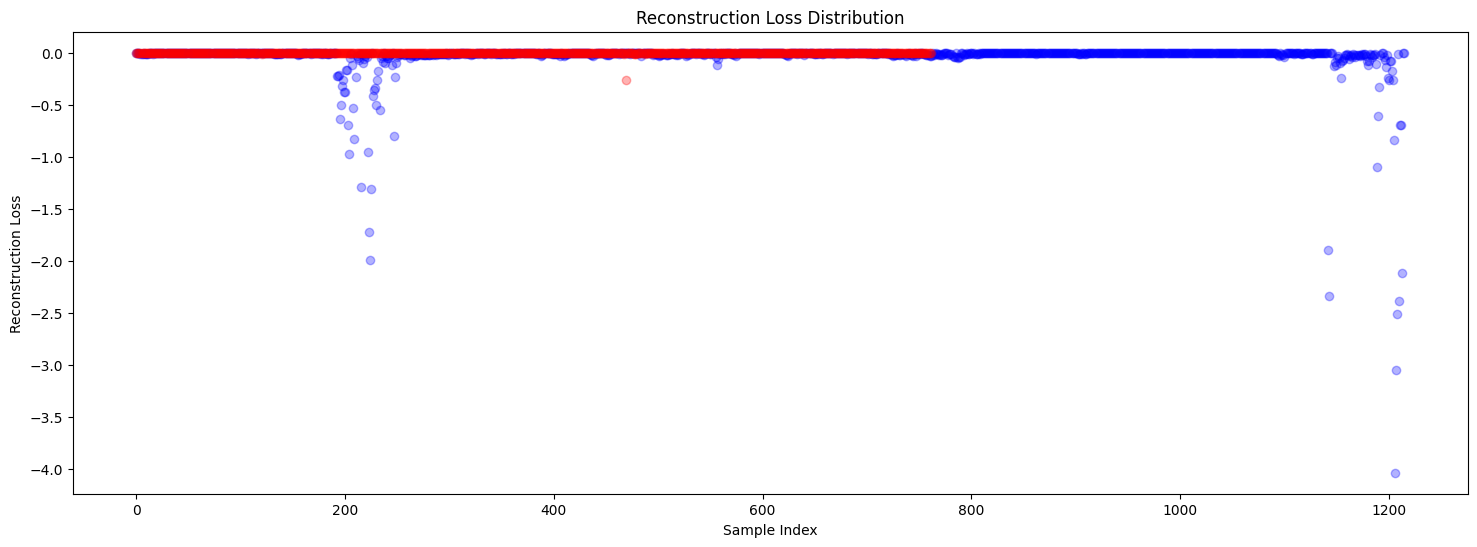

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 6))

plt.scatter(range(len(val_audio_normal)), scores_audio[:len(val_audio_normal)], color='blue', alpha=0.3, label='Train')
plt.scatter(range(len(val_audio)), scores_audio[len(val_audio_normal):], color='red', alpha=0.3, label='Validation')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Distribution')
# plt.ylim(0.0001,-0.06)

In [6]:
# # Train ABOD for audio data
# abod_audio = ABOD(contamination=0.5)  # Adjust contamination parameter as needed
# abod_audio.fit(np.mean(train_audio, axis=-1))

# # Train ABOD for IMU data
# abod_imu = ABOD(contamination=0.5)  # Adjust contamination parameter as needed
# abod_imu.fit(train_imu)

ABOD(contamination=0.5, method='fast', n_neighbors=5)

In [7]:
audio_pre = abod_audio.predict(np.mean(val_audio,axis=-1))
imu_pre = abod_imu.predict(val_imu)
audio_norm_pre = abod_audio.predict(np.mean(val_audio_normal,axis=-1))
imu_norm_pre = abod_imu.predict(val_imu_normal)

In [9]:
distance_audio = abod_audio.decision_function(np.mean(val_audio,axis=-1))
distance_imu   = abod_imu.decision_function(val_imu)

distance_audio_normal = abod_audio.decision_function(np.mean(val_audio_normal,axis=-1))
distance_imu_normal   = abod_imu.decision_function(val_imu_normal)

mean_distance_audio = np.mean(distance_audio_normal)
mean_distance_imu = np.mean(distance_imu_normal)

distance_audio = np.where(distance_audio >= mean_distance_audio, 1, 0)
distance_imu = np.where(distance_imu >= mean_distance_imu, 1, 0)

FN  = np.sum(distance_audio + distance_imu !=0)
TN  = np.sum(distance_audio + distance_imu ==0)


distance_audio_normal = np.where(distance_audio_normal >= mean_distance_audio, 1, 0)
distance_imu_normal = np.where(distance_imu_normal >= mean_distance_imu, 1, 0)

TP = np.sum(distance_audio_normal + distance_imu_normal !=0)
FP = np.sum(distance_audio_normal + distance_imu_normal ==0)
print(TP,FP)
print(FN,TN)


1209 7
762 0
